In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import warnings

import sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model.coordinate_descent import ConvergenceWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [3]:
## 设置字符集，防止中文乱码
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False
## 拦截异常
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [4]:
## 数据加载
path = "datas/iris.data"
names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'cla']
df = pd.read_csv(path, header=None, names=names)
df['cla'].value_counts()
df.head()

,sepal length,sepal width,petal length,petal width,cla
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length    150 non-null float64
sepal width     150 non-null float64
petal length    150 non-null float64
petal width     150 non-null float64
cla             150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


In [6]:
def parseRecord(record):
    result=[]
    r = zip(names,record)
    for name,v in r:
        if name == 'cla':
            if v == 'Iris-setosa':
                result.append(1)
            elif v == 'Iris-versicolor':
                result.append(2)
            elif v == 'Iris-virginica':
                result.append(3)
            else:
                result.append(np.nan)
        else:
            result.append(float(v))
    return result

In [7]:
### 1. 数据转换为数字以及分割
## 数据转换
datas = df.apply(lambda r: pd.Series(parseRecord(r), index=names), axis=1)
## 异常数据删除
datas = datas.dropna(how='any')
## 数据分割
X = datas[names[0:-1]]
Y = datas[names[-1]]
## 数据抽样(训练数据和测试数据分割)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [8]:
print ("原始数据条数:%d；训练数据条数:%d；特征个数:%d；测试样本条数:%d" % (len(X), len(X_train), X_train.shape[1], X_test.shape[0]))

原始数据条数:150；训练数据条数:90；特征个数:4；测试样本条数:60


In [9]:
### 2. 数据标准化
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [10]:
### 3. 特征选择(这里不进行特征选择操作)

In [11]:
### 4. 降维处理(这里不做降维处理)

In [12]:
### 5. 模型构建
lr = LogisticRegressionCV(Cs=np.logspace(-4,1,50), cv=3, fit_intercept=True, penalty='l2', solver='lbfgs', tol=0.01, multi_class='multinomial')
# solver：‘newton-cg’,'lbfgs','liblinear','sag'  default:liblinear
# 'sag'=mini-batch
# 'multi_clss':
lr.fit(X_train, Y_train)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.26486e-04, 1.59986e-04, 2.02359e-04, 2.55955e-04,
       3.23746e-04, 4.09492e-04, 5.17947e-04, 6.55129e-04, 8.28643e-04,
       1.04811e-03, 1.32571e-03, 1.67683e-03, 2.12095e-03, 2.68270e-03,
       3.39322e-03, 4.29193e-03, 5.42868e-03, 6.86649e-03, 8.68511e-03,
       1...., 2.44205e+00, 3.08884e+00,
       3.90694e+00, 4.94171e+00, 6.25055e+00, 7.90604e+00, 1.00000e+01]),
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='multinomial',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.01, verbose=0)

In [13]:
y_test_hot = label_binarize(Y_test, classes=(1,2,3))
lr_y_score = lr.predict_proba(X_test)
lr_y_score[:5]

array([[9.94308711e-06, 1.52409814e-02, 9.84749076e-01],
       [1.40923429e-03, 9.94555266e-01, 4.03549934e-03],
       [9.99070201e-01, 9.29798504e-04, 3.48231198e-10],
       [1.04795442e-06, 5.32800658e-02, 9.46718886e-01],
       [9.92300592e-01, 7.69940419e-03, 3.96991379e-09]])

In [14]:
### 6. 模型效果输出
## 将正确的数据转换为矩阵形式(每个类别使用向量的形式来表述)
y_test_hot = label_binarize(Y_test, classes=(1,2,3))  
# result:[[0, 0, 1], [0, 1, 0], ... , [0, 0, 1]]
## 得到预测的损失值
lr_y_score = lr.decision_function(X_test)
# result:[[ -6.27937676,   1.05548892,   5.22388784], ... ,[ -5.77127503,   1.86074046,   3.91053457]]
## 计算roc的值
lr_fpr, lr_tpr, lr_threasholds = metrics.roc_curve(y_test_hot.ravel(),lr_y_score.ravel())
#  threasholds阈值
## 计算auc的值
lr_auc = metrics.auc(lr_fpr, lr_tpr)
print ("Logistic算法R值：", lr.score(X_train, Y_train))
print ("Logistic算法AUC值：", lr_auc)
### 7. 模型预测
lr_y_predict = lr.predict(X_test)

Logistic算法R值： 0.9777777777777777
Logistic算法AUC值： 0.9269444444444445


In [15]:
##### KNN算法实现
# a. 模型构建
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

# b. 模型效果输出
## 将正确的数据转换为矩阵形式
y_test_hot = label_binarize(Y_test,classes=(1,2,3))
## 得到预测属于某个类别的概率值
knn_y_score = knn.predict_proba(X_test)
## 计算roc的值
knn_fpr, knn_tpr, knn_threasholds = metrics.roc_curve(y_test_hot.ravel(),knn_y_score.ravel())
## 计算auc的值
knn_auc = metrics.auc(knn_fpr, knn_tpr)
print ("KNN算法R值：", knn.score(X_train, Y_train))
print ("KNN算法AUC值：", knn_auc)

# c. 模型预测
knn_y_predict = knn.predict(X_test)

KNN算法R值： 0.9777777777777777
KNN算法AUC值： 0.9694444444444446


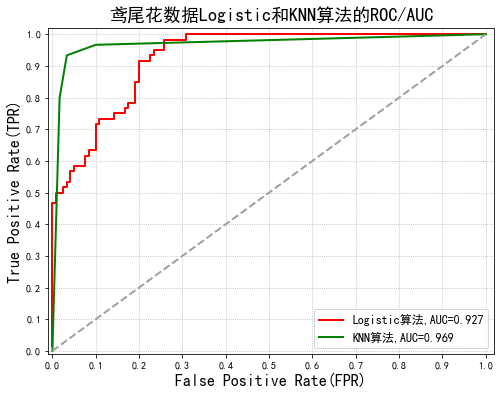

In [16]:
## 画图1：ROC曲线画图
plt.figure(figsize=(8, 6), facecolor='w')
plt.plot(lr_fpr, lr_tpr, c='r', lw=2, label=u'Logistic算法,AUC=%.3f' % lr_auc)
plt.plot(knn_fpr, knn_tpr, c='g', lw=2, label=u'KNN算法,AUC=%.3f' % knn_auc)
plt.plot((0,1),(0,1), c='#a0a0a0', lw=2, ls='--')
plt.xlim(-0.01, 1.02)  # 设置X轴的最大和最小值
plt.ylim(-0.01, 1.02)  # 设置y轴的最大和最小值
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)', fontsize=16)
plt.ylabel('True Positive Rate(TPR)', fontsize=16)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'鸢尾花数据Logistic和KNN算法的ROC/AUC', fontsize=18)
plt.show()

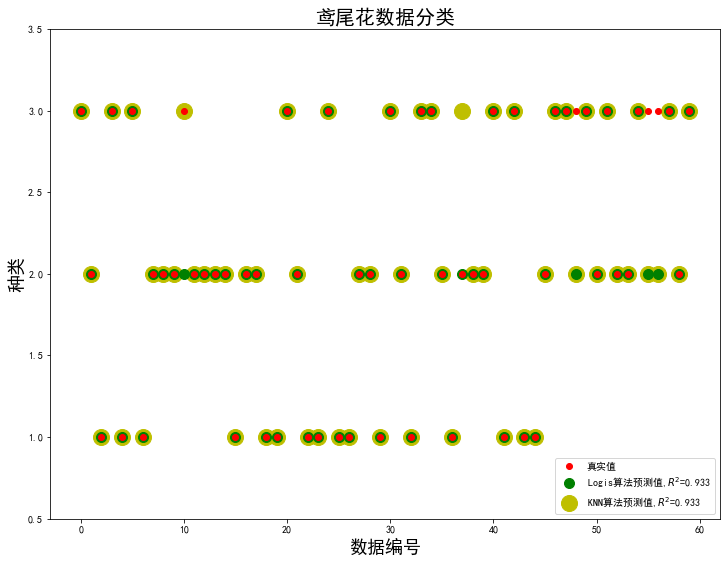

In [17]:
## 画图2：预测结果画图
x_test_len = range(len(X_test))
plt.figure(figsize=(12, 9), facecolor='w')
plt.ylim(0.5, 3.5)
plt.plot(x_test_len, Y_test, 'ro',markersize = 6, zorder=3, label=u'真实值')
plt.plot(x_test_len, lr_y_predict, 'go', markersize = 10, zorder=2, label=u'Logis算法预测值,$R^2$=%.3f' % lr.score(X_test, Y_test))
plt.plot(x_test_len, knn_y_predict, 'yo', markersize = 16, zorder=1, label=u'KNN算法预测值,$R^2$=%.3f' % knn.score(X_test, Y_test))
plt.legend(loc = 'lower right')
plt.xlabel(u'数据编号', fontsize=18)
plt.ylabel(u'种类', fontsize=18)
plt.title(u'鸢尾花数据分类', fontsize=20)
plt.show()